In [29]:
#輸出圖檔名、圖檔大小############
figure_name = "NPC_UMAP_result"
dot_size = 3
length, width = 12, 8

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap

In [31]:
data = pd.read_excel("./GTEx_NPC_data.xlsx", engine='openpyxl', header = None, index_col=0)
data = data.to_numpy()
label_data = pd.read_excel("./GTEx_NPC_data.xlsx", engine='openpyxl', header = None, index_col=None, usecols = "A")
label_data = label_data.to_numpy().flatten()

In [32]:
row_sums = data.sum(axis=1)
normalize_data = data / row_sums[:, np.newaxis]

#### UMAP參數修改

In [33]:
umap_x = umap.UMAP().fit_transform(normalize_data)

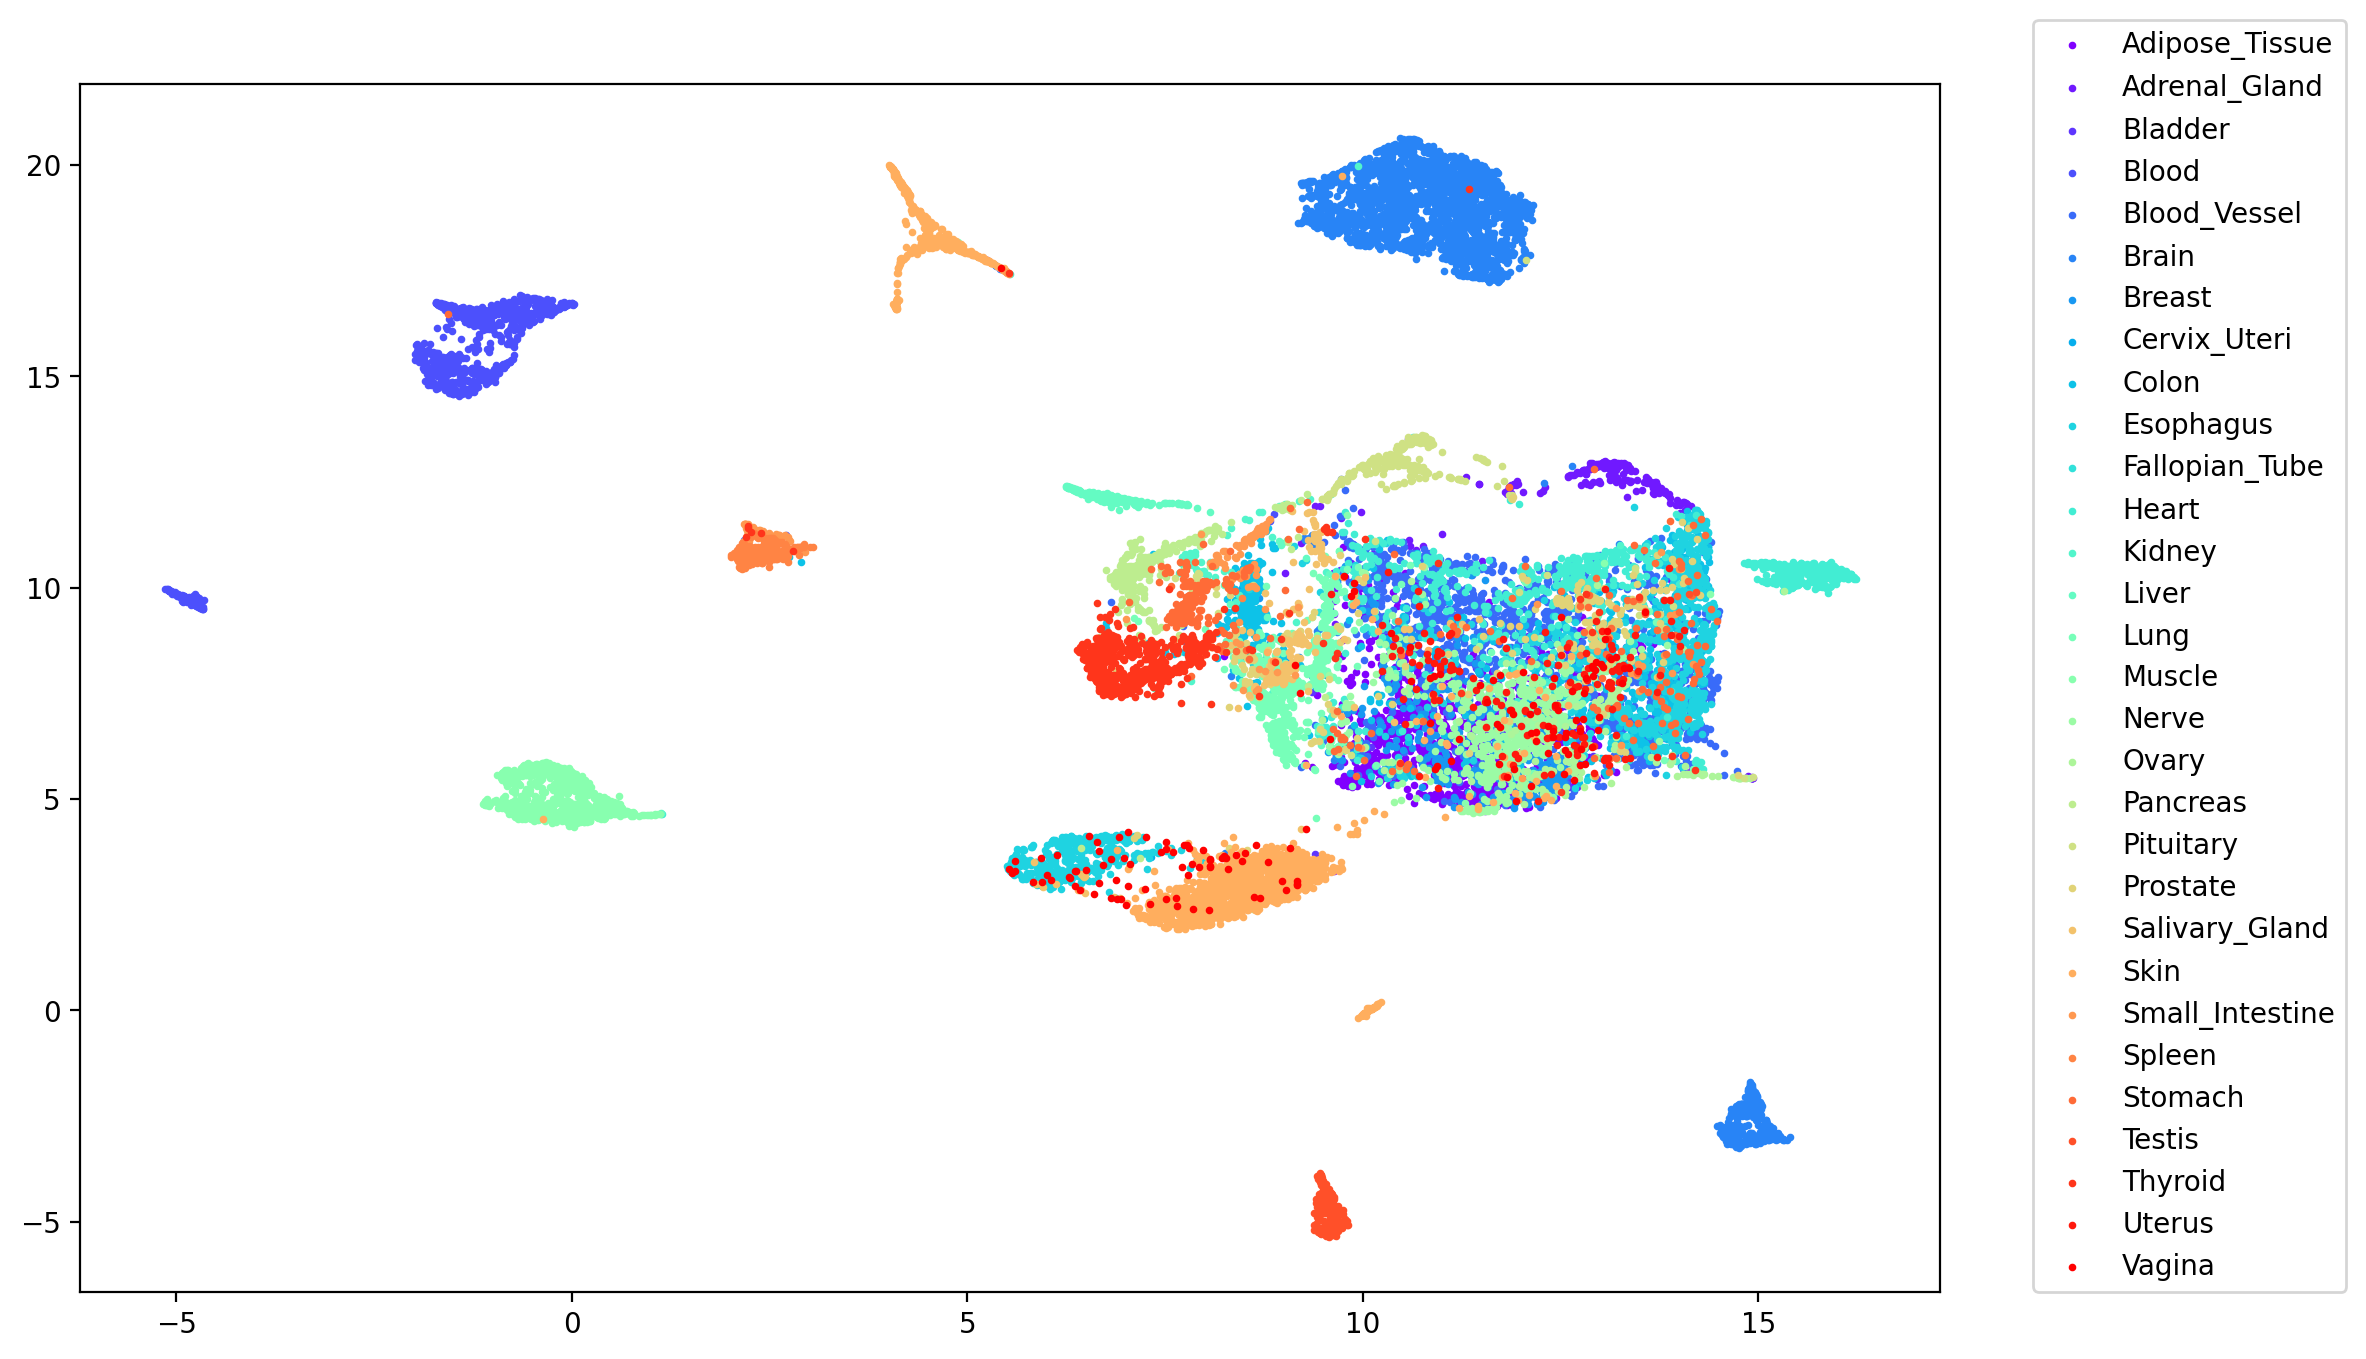

In [37]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

number = np.unique(label_data).shape[0]
cmap = plt.get_cmap('rainbow')
colors = [cmap(i) for i in np.linspace(0, 1, number)]
color_dic = {}
cancers = np.unique(label_data).tolist()
for i in range(number):
    color_dic[cancers[i]] = colors[i]

x_dot = umap_x[:,0]
y_dot = umap_x[:,1]
fig, ax = plt.subplots(figsize=(length, width),dpi=200)
for g in np.unique(label_data):
	ix = np.where(label_data == g)
	ax.scatter(x_dot[ix], y_dot[ix], c = color_dic[g], label = g, s = dot_size)
ax.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

plt.savefig("./result/%s.jpg" % figure_name, bbox_inches = 'tight')